In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

TOPSIS Ranking for Text Classification Models:
        Model  TOPSIS Score
0      ALBERT      0.935395
1  DistilBERT      0.751880
2     RoBERTa      0.320117
3        BERT      0.295476
4       XLNet      0.075154


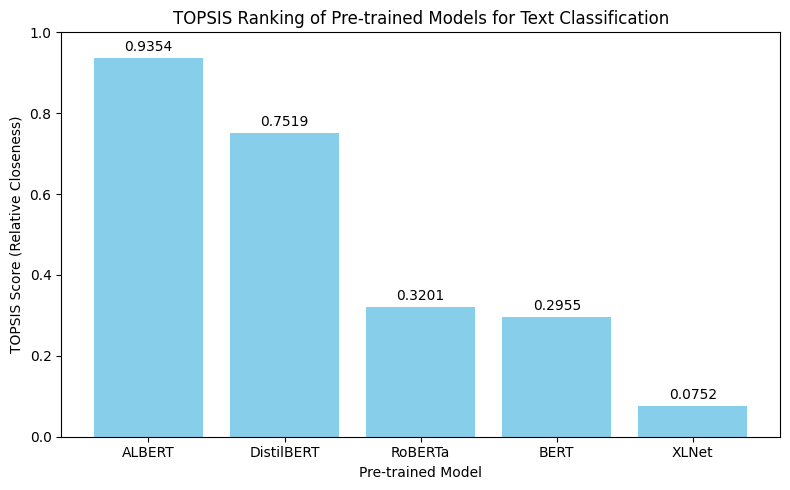

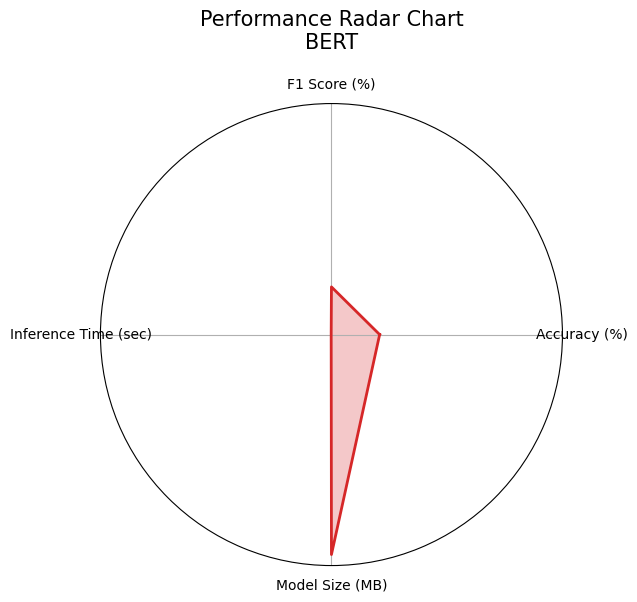

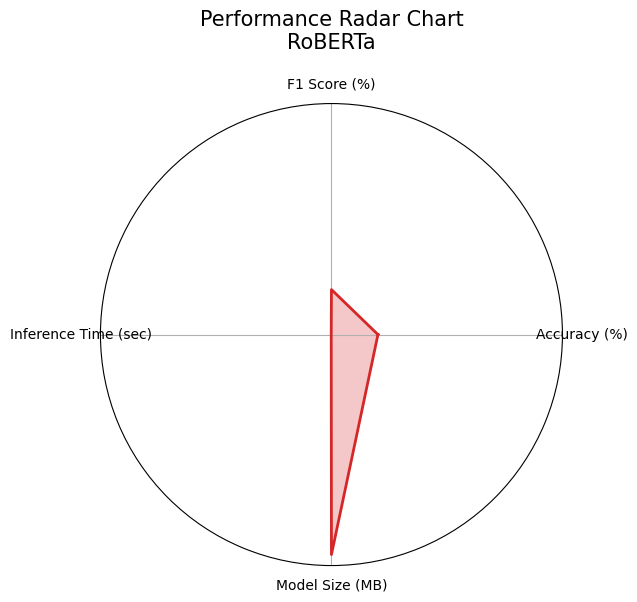

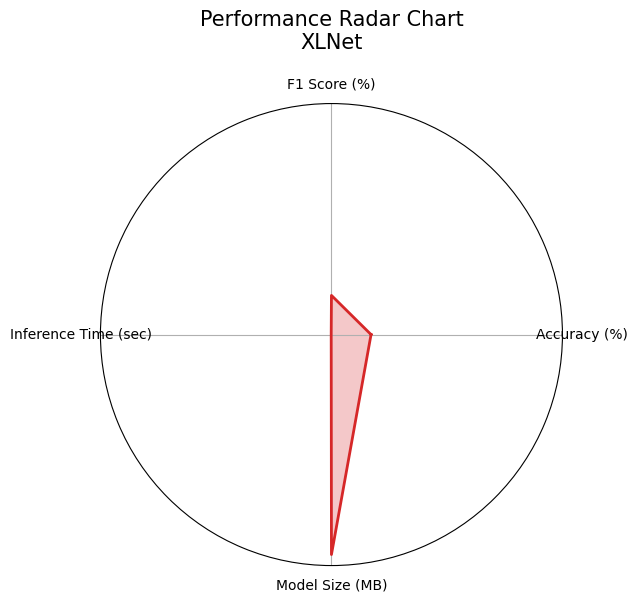

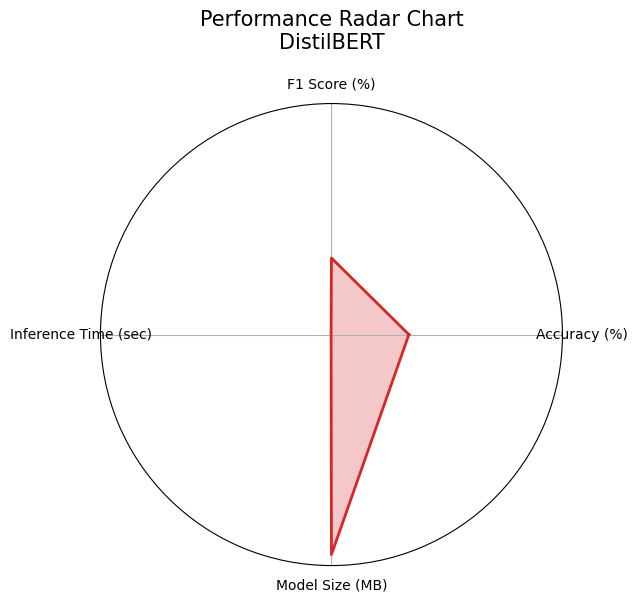

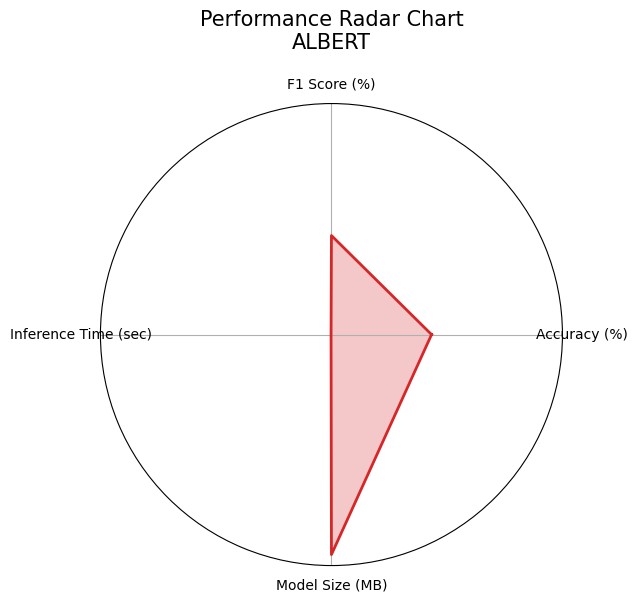

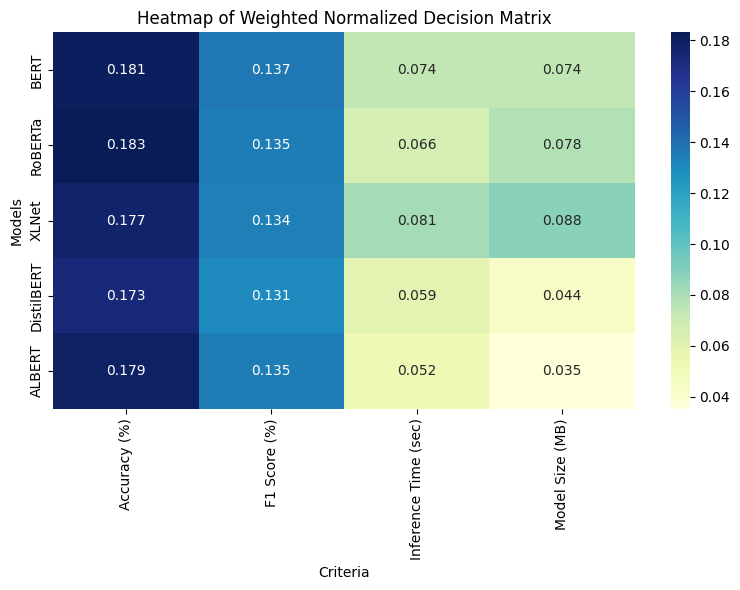

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

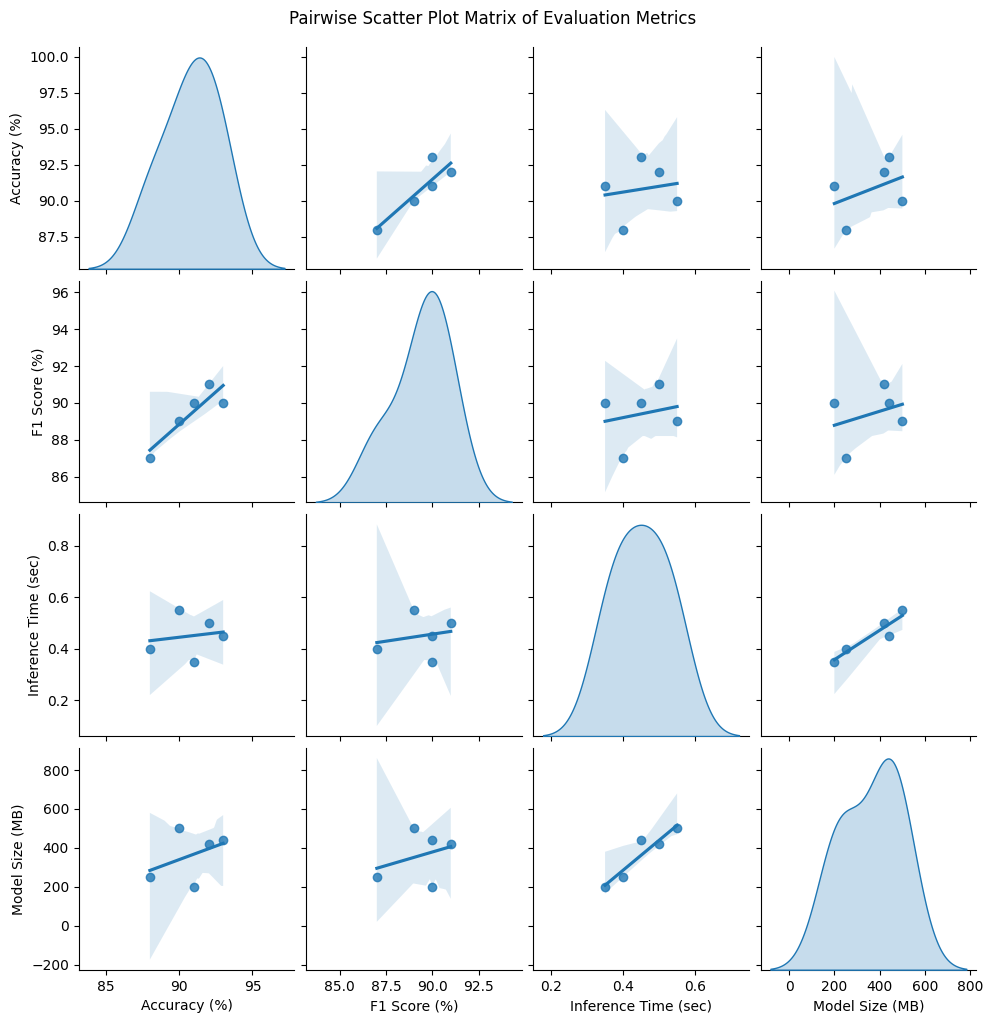

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Define the decision matrix and parameters
# ---------------------------
models = ['BERT', 'RoBERTa', 'XLNet', 'DistilBERT', 'ALBERT']
criteria = ['Accuracy (%)', 'F1 Score (%)', 'Inference Time (sec)', 'Model Size (MB)']

# Hypothetical decision matrix values for text classification:
decision_matrix = np.array([
    [92, 91, 0.50, 420],   # BERT
    [93, 90, 0.45, 440],   # RoBERTa
    [90, 89, 0.55, 500],   # XLNet
    [88, 87, 0.40, 250],   # DistilBERT
    [91, 90, 0.35, 200]    # ALBERT
])

# Weights for each criterion (should sum to 1)
weights = np.array([0.4, 0.3, 0.15, 0.15])

# Specify the type for each criterion: 'benefit' means higher is better, 'cost' means lower is better.
criteria_type = ['benefit', 'benefit', 'cost', 'cost']

# ---------------------------
# 2. Normalize the Decision Matrix (vector normalization)
# ---------------------------
norm_matrix = decision_matrix / np.sqrt((decision_matrix ** 2).sum(axis=0))

# ---------------------------
# 3. Construct the Weighted Normalized Decision Matrix
# ---------------------------
weighted_norm = norm_matrix * weights

# ---------------------------
# 4. Determine the Ideal Best and Ideal Worst Solutions
# ---------------------------
ideal_best = np.zeros(weighted_norm.shape[1])
ideal_worst = np.zeros(weighted_norm.shape[1])
for j in range(weighted_norm.shape[1]):
    if criteria_type[j] == 'benefit':
        ideal_best[j] = weighted_norm[:, j].max()
        ideal_worst[j] = weighted_norm[:, j].min()
    else:
        ideal_best[j] = weighted_norm[:, j].min()
        ideal_worst[j] = weighted_norm[:, j].max()

# ---------------------------
# 5. Calculate the Distance of Each Alternative from the Ideal Best and Worst
# ---------------------------
distance_best = np.sqrt(((weighted_norm - ideal_best) ** 2).sum(axis=1))
distance_worst = np.sqrt(((weighted_norm - ideal_worst) ** 2).sum(axis=1))

# ---------------------------
# 6. Calculate the TOPSIS Score (Relative Closeness to the Ideal Solution)
# ---------------------------
scores = distance_worst / (distance_best + distance_worst)

results_df = pd.DataFrame({
    'Model': models,
    'TOPSIS Score': scores
}).sort_values(by='TOPSIS Score', ascending=False).reset_index(drop=True)

# ---------------------------
# 7. Display the Ranking Results
# ---------------------------
print("TOPSIS Ranking for Text Classification Models:")
print(results_df)

# ---------------------------
# 8. Visualization Section
# ---------------------------

# --- Visualization 1: Bar Chart of TOPSIS Scores ---
plt.figure(figsize=(8, 5))
bars = plt.bar(results_df['Model'], results_df['TOPSIS Score'], color='skyblue')
plt.xlabel("Pre-trained Model")
plt.ylabel("TOPSIS Score (Relative Closeness)")
plt.title("TOPSIS Ranking of Pre-trained Models for Text Classification")
plt.ylim(0, 1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# --- Visualization 2: Radar Charts for Each Model ---
def create_radar_chart(data, categories, model_name):
    # Number of variables we're plotting.
    num_vars = len(categories)
    
    # Compute angle for each axis in the plot (in radians)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    # The plot is made by completing the loop, so we "close" the plot.
    angles += angles[:1]
    
    # Values to plot. We use the raw decision matrix values (or you could use normalized values)
    values = data.tolist()
    values += values[:1]
    
    # Initialize the radar plot.
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, color='tab:red', linewidth=2)
    ax.fill(angles, values, color='tab:red', alpha=0.25)
    
    # Fix the labels for each axis.
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    
    # Set the range for the radial axis.
    # For benefit criteria (accuracy, F1 score) the maximum is 100; for cost criteria, choose a suitable maximum.
    # Here we simply choose a range that covers our hypothetical data.
    ax.set_rlabel_position(30)
    plt.yticks([], [])
    plt.title(f'Performance Radar Chart\n{model_name}', size=15, y=1.1)
    plt.show()

# Create radar charts for each model using the raw decision matrix values.
for i, model in enumerate(models):
    create_radar_chart(decision_matrix[i, :], criteria, model)

# --- Visualization 3: Heatmap of Weighted Normalized Decision Matrix ---
# Create a DataFrame for better visualization with seaborn
weighted_norm_df = pd.DataFrame(weighted_norm, columns=criteria, index=models)
plt.figure(figsize=(8, 6))
sns.heatmap(weighted_norm_df, annot=True, cmap='YlGnBu', fmt=".3f")
plt.title("Heatmap of Weighted Normalized Decision Matrix")
plt.xlabel("Criteria")
plt.ylabel("Models")
plt.tight_layout()
plt.show()

# --- Visualization 4: Pairwise Scatter Plot Matrix ---
# Create a DataFrame for the original decision matrix
dm_df = pd.DataFrame(decision_matrix, columns=criteria, index=models)
sns.pairplot(dm_df, kind='reg', diag_kind='kde')
plt.suptitle("Pairwise Scatter Plot Matrix of Evaluation Metrics", y=1.02)
plt.show()
